#Appunti


---

Come funziona K-NN?


---


1. Prendiamo un punto di ground living area (x), e per quella specifica x vado a trovare i "k" dati/punti più vicini a questa retta. \

2. Come faccio a dire che sono i più vicini? Devo scegliere una metrica. \
Poi cosa faccio?  
3. Per questa x e questi tre punti più vicini, una buona guess è la media di questi tre valori.
4. Lo faccio per ogni x, e se vado a connettere ciascuna di queste medie, creo la "retta". Questo metodo vede i dati in modo non lineare.


---


*  Quando decido che k=1 e quindi prendo solo un punto, quasi sicuramente avrò un modello che fa overfitting, quindi con k più basso faccio overfitting, con k più alto è più probabile che faccio underfitting e perde accuratezza, mentre se prendo tutti i punti mi viene una retta piatta. 
---
***Iper-parametri del modello: perché è un modello non parametrico***


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# impostazione per vedere tutte le colonno di un DataFrame
pd.set_option('display.max_columns',None)

In [ ]:
df = pd.read_csv('housing.csv')

In [ ]:
df.shape

(1460, 81)

TRAIN / TEST SPLIT

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.25, shuffle=True, random_state=22)

FEATURES

In [ ]:
features = ['OverallQual', 'GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath','TotRmsAbvGrd']
#queste sono features sono solo numeriche
X_train = train_df[features].copy()
y_train = train_df['SalePrice'].copy()

X_test = test_df[features].copy()
y_test = test_df['SalePrice'].copy()

In [ ]:
### definisco già prima la funzione di evaluation

def evaluate(targets, preds, title, plots=True, verbose=True):

    from sklearn.metrics import mean_absolute_error, r2_score
    
    mae = mean_absolute_error(targets, preds)
    r2 = r2_score(targets, preds)
    
    if verbose:
        print(title)
        print('MAE: ', mae)
        print('R2: ', r2)
    
    if plots:
        ###### previsioni VS targets
        sns.scatterplot(x=targets, y=preds)
        ###### retta di perfect fit
        plt.plot(range(0,targets.max()), range(0,targets.max()), label='perfect fit')
        plt.title(title)
        plt.legend()
        plt.show()
    
    return {'mae':mae, 'r2':r2}

# K-NEAREST NEIGHBORS (KNN)

In [ ]:
### FITTING
from sklearn.neighbors import KNeighborsRegressor #regressor perché c'è anche il classifier
 
model = KNeighborsRegressor() #n neighbors è 5 in default (sono 5 i punti presi vicino ad x)
model = model.fit(X_train, y_train)

In [ ]:
### EVALUATION

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET')
test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET')

### K parameter

Facciamo un ciclo cambiando il valore di K, cioè il numero di vicini da considerare

In [ ]:
train_r2_list = list()
test_r2_list = list()

k_list = range(1, 20)

for k in k_list:
    
    print('\nK:',k)
    
    model = KNeighborsRegressor(n_neighbors = k)
    model = model.fit(X_train, y_train)
    
    ### EVALUATION
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET', plots=False, verbose=True) #plots=False così non viene il grafico
    test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET', plots=False, verbose=True)
    
    train_r2_list += [train_metrics['r2']]
    test_r2_list += [test_metrics['r2']]
        

In [ ]:
plt.plot(k_list, train_r2_list, label='TRAIN')
plt.plot(k_list, test_r2_list, label='TEST')
plt.legend()
plt.show() #questo è il plot dell'r quadro, perché con k più alto l'accuratezza è inferiore, e r2 diminuisce all'aumentare di k
#L'overfitting è la differenza tra train set e test set, quindi quello migliore è 6 perché r2 è più alto; significa che quei 6 punti che ho preso (k=6) rappresentano meglio l'eterogenità del gruppo e quindi riesco a fare una previsione più accurata

Si vede bene per k<5 c'è un forte overfitting, in quanto il modello performa benissimo sul train set e male sul test set. Da 5 in poi l'overfitting scompare, a discapito però della performance assoluta, che decresce lentamente

### Features scaling

K-NN è molto influenzabile dalla scala delle variabili (es. metri quadri della casa sono molto diverse dal numero di macchine nel garage)

Un aspetto che può influenzare fortemente la bontà delle previsioni del k-NN sono le diverse scale a cui si presentano le varie features. Per esempio è evidente che la superficie di un piano non è paragonabile con il numero di macchine del garage.

In [ ]:
sns.displot(X_train)
plt.show() #è la conta 

Per questo motivo si usa normalizzare i dati

#### MinMaxScaler()

In [ ]:
from sklearn.preprocessing import MinMaxScaler #è più intuitivo, ma tipicamente si usa standard scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) #lo scaler è già fittato, posso fare fitting solo sul train set, non test se

Lo scaler mi restituisce un array quindi lo trasformo in un dataFrame

In [ ]:
pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [ ]:
sns.displot(X_train_scaled)
plt.show() 

Si sono persi i nomi delle feature perchè lo scaler dà in output un numpy.array multidimensionale. Per recuperarle basta ritrasformarlo in un DataFrame:

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns) #DataFrame normalizzato
sns.displot(X_train_scaled)
plt.show()

Come si vede il MinMaxScaler, basandosi sul massimo e sul minimo di ongi feature, ha il vantaggio di rendere ben paragonabili le scale delle features tra di loro. Potrebbe essere una buona scelta in questo caso, ma non è detto però che sia la scelta migliore in ogni caso. Queste features sono tutte positive, cioè non sono mai minori di zero. Ci sono spesso innvece contesti in cui alcune feature hanno anche valori minori di zero, e potrebbe essere una buona scelta quella di avere tutte le feature centrate sullo zero. A questo scopo per esempio si può usare lo StandardScaler.

#### StandardScaler()

Lo standard scaler si basa sulle deviazioni standard  di ogni feature, e come si vede facilmente, le centra tutte attorno allo zero.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
sns.displot(X_train_scaled)
plt.show()

In [ ]:
### FITTING
from sklearn.neighbors import KNeighborsRegressor
 
model = KNeighborsRegressor()
model = model.fit(X_train_scaled, y_train)

In [ ]:
### EVALUATION

train_preds = model.predict(X_train_scaled)
test_preds = model.predict(X_test_scaled)

train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET')
test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET')

# DECISION TREE

###**Appunti ed inizio**

Un albero decisionale è un modello **NON PARAMETRICO**  

(Non fa nessuna assunzione sulla struttura che potrebbero avere i dati)

E' come fare un if però non devi mettere tu i parametri ogni volta, lo fa in automatico. 

Gli alberi decisionali hanno il problema che se cambi di pochissimo il training set l'albero cambia completamente.

E' comodo perché:
*  Si può usare per vedere quali sono le features più importanti
*  Non ha problemi particolari con valori mancanti, cose non normalizzate etc

I contro:
*  Tendono a fare molto over-fitting perché sono così specifici sul training set
(infatti ci sono parametri come ad esempio max_depth che indicano il livello a cui fermarsi)

**Tipicamente si usa per la data exploration (è un altro modo di farla oltre alla correlazione di Pearson ad esempio).**


Quando diventa un buon predittore?\
Quando creo una random forest, ovvero un insieme di alberi.
Alla fine, fa una media di tutto, il che è ottimo per l'over fitting perché non sono specifico ma utilizzo vari dati.


TRAIN SET
MAE:  491.6500761035007
R2:  0.9986098393167883


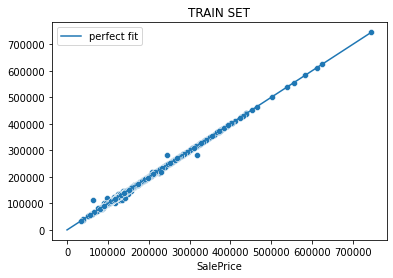

TEST SET
MAE:  27755.875342465755
R2:  0.777018120562293


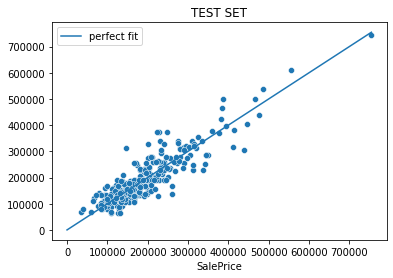

In [ ]:
from sklearn.tree import DecisionTreeRegressor

### FITTING

model = DecisionTreeRegressor()
model = model.fit(X=X_train, y=y_train)

### EVALUATION

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# usiamo la funzione che abbiamo definito prima
train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET')
test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET')


E' evidente che c'è dell'overfitting, perchè sul training set ho delle previsioni praticamente perfette, mentre sul test set va molto peggio.

Posso plottare le scelte dell'albero decisionale (conviene settare max_depth basso)

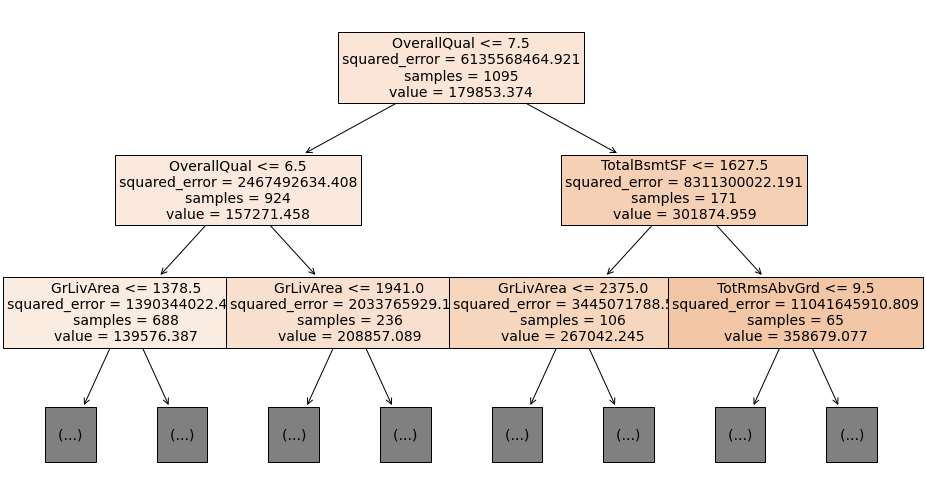

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(16,9))
_ = plot_tree(model, max_depth=2, filled=True, feature_names=list(X_train.columns), fontsize=14) #quando non vuoi niente, non vuoi assegnare niente all'output, mettiamo un underscore (_),

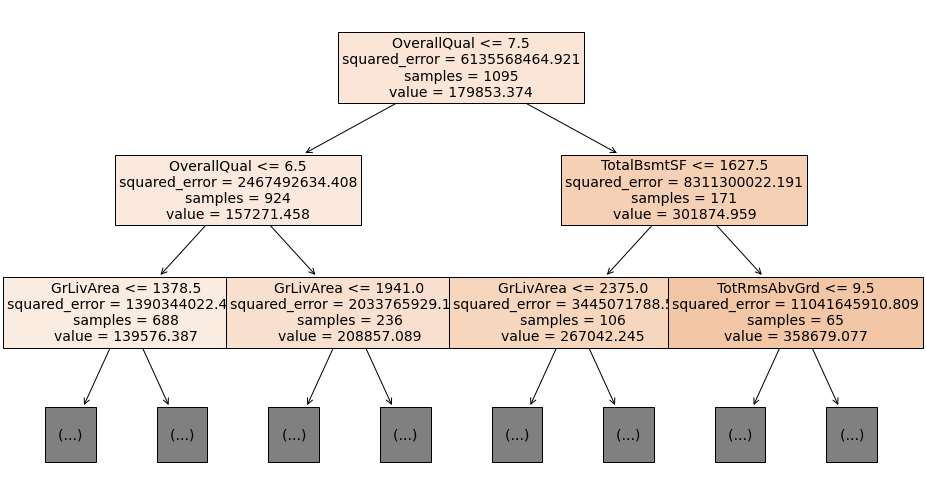

In [ ]:
#secondo modo per farlo
from sklearn import tree
plt.figure(figsize=(16,9))
_ = tree.plot_tree(model, max_depth=2, filled=True, feature_names=list(X_train.columns), fontsize=14) #max_depth=2 è il numero di livelli (layers), filled= riempi le caselle di un colore in base a quanto è buona la classificazione

Posso anche ricavare l'importanza relativa delle feature. Gli alberi decisionali si usano in effetti anche in fase di **Exploratory Data Analysis(EDA)**, quando si vuole capire quali sono le feature più importanti (fino ad ora avevamo usato solo le correlazioni)

### Features importance

In [ ]:
pd.Series(model.feature_importances_, index=X_train.columns ) #mi da' le importante relative ad ogni feature 

#model.feature_importances_ riporta un array con i pesi senza la categoria 

OverallQual     0.595716
GrLivArea       0.191720
GarageCars      0.028725
TotalBsmtSF     0.132969
FullBath        0.003936
TotRmsAbvGrd    0.046933
dtype: float64

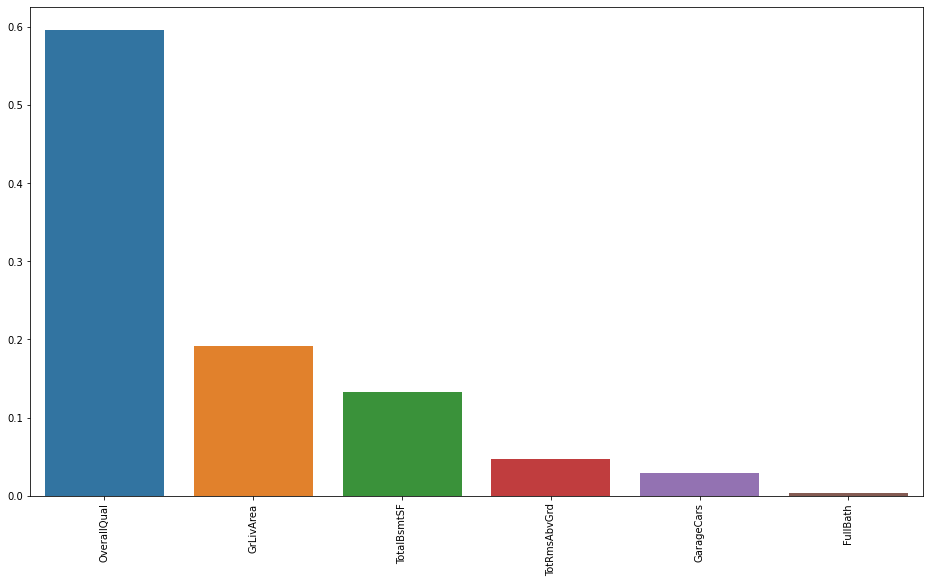

In [ ]:
#posso creare un barplot per vedere come sono distribuiti i pesi 
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(16,9))
sns.barplot(x=importances.index, y=importances)
plt.xticks(rotation=90)
plt.show()

Proviamo a evitare l'overfitting limitando la max_depth dell'albero decisionale. Facciamo un ciclo su più valori. 
NB ci sarebbero tanti altri parametri su cui andare a lavorare ma noi ci limiteremo solo a max_depth

### max_depth parameter

In [ ]:
depth_list = range(3,15,1)
#provo varie max depth
train_r2_list = list()
test_r2_list = list()

for n in depth_list:
    
    print('\nMax_depth:',n)
    
    model = DecisionTreeRegressor(max_depth=n)
    model = model.fit(X=X_train, y=y_train)
    
    ### EVALUATION
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # usiamo la funzione che abbiamo definito prima
    train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET', plots=False, verbose=True)
    test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET', plots=False, verbose=True)
    
    train_r2_list += [train_metrics['r2']]
    test_r2_list += [test_metrics['r2']]


Max_depth: 3
TRAIN SET
MAE:  29270.21975592393
R2:  0.730334595971369
TEST SET
MAE:  30764.064659985288
R2:  0.7312838665785322

Max_depth: 4
TRAIN SET
MAE:  24378.56382544377
R2:  0.8192438074712409
TEST SET
MAE:  26660.63613719023
R2:  0.7981006708981189

Max_depth: 5
TRAIN SET
MAE:  21231.664855187322
R2:  0.8655144100379026
TEST SET
MAE:  23172.325620994605
R2:  0.855396454900917

Max_depth: 6
TRAIN SET
MAE:  18310.10230337116
R2:  0.8986616095038582
TEST SET
MAE:  23379.66367972189
R2:  0.8438626603859894

Max_depth: 7
TRAIN SET
MAE:  16142.613663086846
R2:  0.9210458884729397
TEST SET
MAE:  22693.868583940734
R2:  0.8475000654014094

Max_depth: 8
TRAIN SET
MAE:  13217.368592253477
R2:  0.9402291991165947
TEST SET
MAE:  24721.079684018812
R2:  0.8140197637756194

Max_depth: 9
TRAIN SET
MAE:  11204.878075864055
R2:  0.95415500731588
TEST SET
MAE:  25111.326540019752
R2:  0.8060013200803778

Max_depth: 10
TRAIN SET
MAE:  8496.90391342029
R2:  0.9699074046201834
TEST SET
MAE:  26468

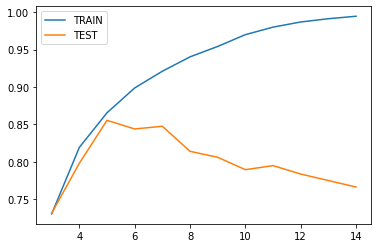

In [ ]:
plt.plot(depth_list, train_r2_list, label='TRAIN')
plt.plot(depth_list, test_r2_list, label='TEST')
plt.legend()
plt.show()

Max_depth fa l'effetto contrario di K, all'aumentare di max_depth aumenta l'albero ed il rischio di over fitting.

E' evidente come all'aumentare di max_depth (e quindi della complessità del modello) aumenti anche l'overfitting, cioè la distanza tra le performance di training e di test. Potremmo usare mex_depth=5, dove c'è il massimo sul test set.
Il problema dell'overfitting si può in parte risolvere usando un ensable di alberi decisionali: le **Random Forest**

# RANDOM FOREST

TRAIN SET
MAE:  8557.27177706023
R2:  0.9697805835050912


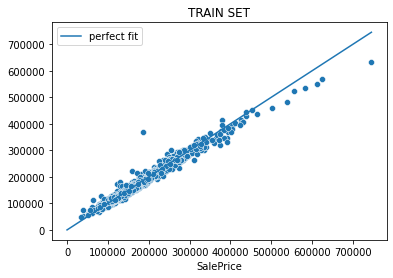

TEST SET
MAE:  20883.75280471036
R2:  0.8725943379762002


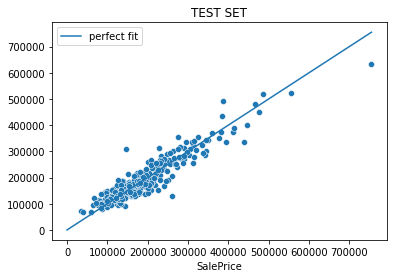

In [ ]:
from sklearn.ensemble import RandomForestRegressor

### FITTING
model = RandomForestRegressor()
model = model.fit(X=X_train, y=y_train)

### EVALUATION
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# usiamo la funzione che abbiamo definito prima
train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET')
test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET')

Senza settare alcun parametro già l'overiftting, seppure ancora presente, è molto meno pronunciato rispetto all'albero decisionale.

Anche qui posso ricavare l'importanza relativa delle feature

### Features importance

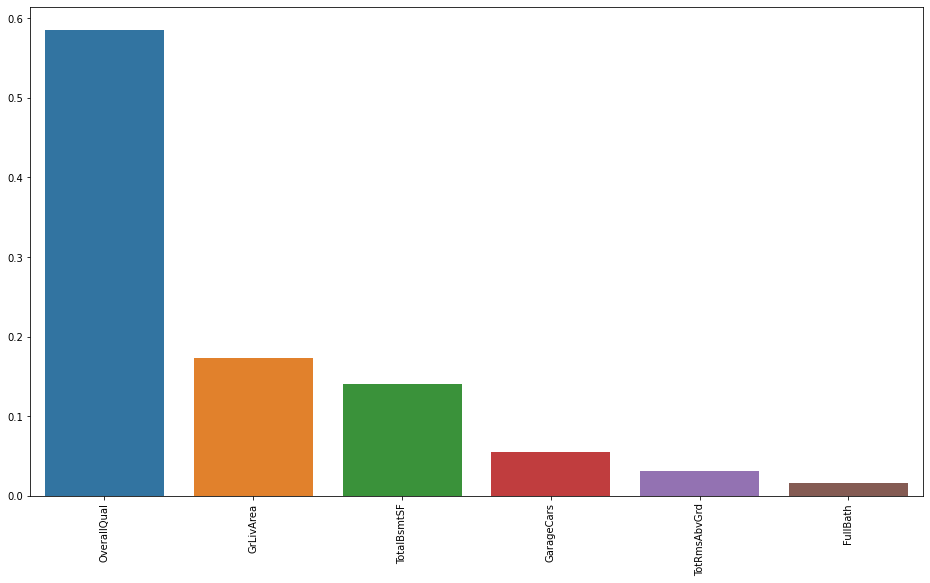

In [ ]:
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(16,9))
sns.barplot(x=importances.index, y=importances)
plt.xticks(rotation=90)
plt.show()

### max_depth parameter

Facendo lo stesso lavoro di prima possiamo fare un primo tuning del parametro max_depth

In [ ]:
depth_list = range(3,15,1)

train_r2_list = list()
test_r2_list = list()

for n in depth_list:
    print('\nMax_depth:',n)
    model = RandomForestRegressor(max_depth=n)
    model = model.fit(X=X_train, y=y_train)
    
    ### EVALUATION
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # usiamo la funzione che abbiamo definito prima
    train_metrics = evaluate(targets=y_train, preds=train_preds, title='TRAIN SET', plots=False, verbose=True)
    test_metrics = evaluate(targets=y_test, preds=test_preds, title='TEST SET', plots=False, verbose=True)
    over = train_metrics['r2']-test_metrics['r2']
    print('La differenza è: ' , over)
    train_r2_list += [train_metrics['r2']]
    test_r2_list += [test_metrics['r2']]


Max_depth: 3
TRAIN SET
MAE:  24525.859477823546
R2:  0.7924854859474254
TEST SET
MAE:  24650.289547772685
R2:  0.8071324811227926
La differenza è:  -0.014646995175367161

Max_depth: 4
TRAIN SET
MAE:  21311.003228033787
R2:  0.8491989213918609
TEST SET
MAE:  21871.026130565093
R2:  0.8452580724706322
La differenza è:  0.003940848921228701

Max_depth: 5
TRAIN SET
MAE:  19074.37586228755
R2:  0.8801148681936919
TEST SET
MAE:  20160.140694324717
R2:  0.870660065356212
La differenza è:  0.009454802837479903

Max_depth: 6
TRAIN SET
MAE:  17249.77083331109
R2:  0.9050720495429764
TEST SET
MAE:  19801.62013464264
R2:  0.8787648832156209
La differenza è:  0.026307166327355525

Max_depth: 7
TRAIN SET
MAE:  15614.913200985035
R2:  0.9237587296524394
TEST SET
MAE:  19881.198029767682
R2:  0.8823004217418999
La differenza è:  0.041458307910539505

Max_depth: 8
TRAIN SET
MAE:  14030.168720237176
R2:  0.9367192534274782
TEST SET
MAE:  20409.727005847282
R2:  0.8734192669597911
La differenza è:  0.06

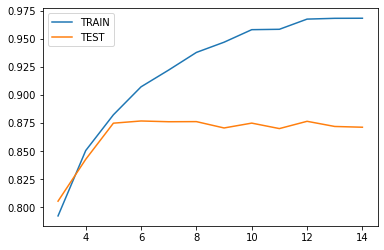

In [ ]:
plt.plot(depth_list, train_r2_list, label='TRAIN')
plt.plot(depth_list, test_r2_list, label='TEST')
plt.legend()
plt.show()

Possiamo scegliere di usare max_depth = 5, dove c'è il picco di performance sul test set

R2 è più alto.

#Overfitting


Se performo meglio sul train set rispetto al test set sono in caso di over fitting. Quindi r2 del train set è più alto di r2 del test set.

#Come fare la previsione su un df senza target

hold_out_df = pd.read_csv('insurance_hold_out.csv')\
new_predictions = model.predict(X_hold_out) #applico il mio modello (model è il mio modello) \
new_predictions.to_csv('scelgoilnome'.csv)

(index=hold_out.idex) per mettere l'indice in new predictions


#Come gestire i valori nulli